# Evolver Loop 72 Analysis

Goals:
1. Re-check CV↔LB relationship using **actual** submission history from `session_state.json`.
2. Quantify how much of the gap could plausibly be reduced by **intercept-reduction** strategies.
3. Prototype an **applicability-domain shrinkage** layer on top of the now template-safe A0 model outputs (no retraining): distance-to-training → alpha(x) → blend toward conservative baseline.
4. Pull ideas from public kernels (esp. `mixall` and `ens-model`).

We are NOT optimizing CV; we are trying to change the CV→LB mapping (reduce intercept).

In [3]:
import json, numpy as np, pandas as pd
from pathlib import Path

state=json.loads(Path('/home/code/session_state.json').read_text())
subs=pd.DataFrame(state.get('submissions', []))
# coerce numeric; some entries may have '' or None
subs['cv_score']=pd.to_numeric(subs['cv_score'], errors='coerce')
subs['lb_score']=pd.to_numeric(subs['lb_score'], errors='coerce')
subs=subs.dropna(subset=['cv_score','lb_score']).copy()
subs=subs.sort_values('timestamp')
subs[['experiment_id','cv_score','lb_score']].tail(), subs.shape

(   experiment_id  cv_score  lb_score
 8        exp_024  0.008689   0.08929
 9        exp_026  0.008465   0.08875
 10       exp_030  0.008298   0.08772
 11       exp_035  0.009825   0.09696
 21       exp_068  0.008303   0.08774,
 (13, 7))

In [4]:
import sklearn
from sklearn.linear_model import LinearRegression

X=subs[['cv_score']].values
y=subs['lb_score'].values
lr=LinearRegression().fit(X,y)
pred=lr.predict(X)
r2=lr.score(X,y)
(lr.coef_[0], lr.intercept_, r2)

(4.337233785433589, 0.0522576273173532, 0.9572725483646047)

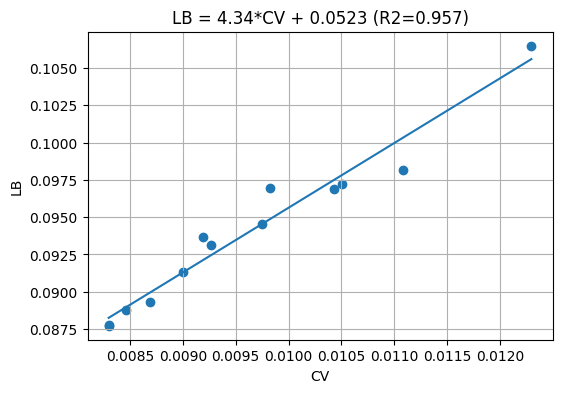

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(subs['cv_score'], subs['lb_score'])
xs=np.linspace(subs['cv_score'].min(), subs['cv_score'].max(), 100)
plt.plot(xs, lr.predict(xs.reshape(-1,1)))
plt.xlabel('CV'); plt.ylabel('LB');
plt.title(f'LB = {lr.coef_[0]:.2f}*CV + {lr.intercept_:.4f} (R2={r2:.3f})')
plt.grid(True)
plt.show()

In [6]:
target=0.0347
required_cv=(target - lr.intercept_)/lr.coef_[0]
required_cv

-0.00404811642303436

## Applicability-domain shrinkage prototype

Idea: detect "OOD-ness" by distance of a test point to training distribution in **solvent descriptor space** (or learned embeddings), then blend prediction toward a conservative fallback.

We can prototype with:
- Features: solvent descriptors only (Spange + DRFP filtered + ACS PCA), plus mixture composition.
- Distance: kNN average Euclidean after standardization.
- Alpha mapping: isotonic regression from distance → optimal alpha in CV (minimizes MSE when blending).
- Fallback: per-target mean of training folds.

Then apply to fold predictions from A0-like model and evaluate CV effect. If CV worsens slightly but we expect LB intercept reduction, it may still help.

We need fold predictions from a baseline model. For speed, we can fit a fast ridge baseline to generate predictions; in the executor we will implement the shrinkage inside the full model class.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.isotonic import IsotonicRegression

DATA_PATH='/home/data'
INPUT_LABELS_FULL_SOLVENT=["Residence Time","Temperature","SOLVENT A NAME","SOLVENT B NAME","SolventB%"]
TARGET_LABELS=["Product 2","Product 3","SM"]

full=pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')
X=full[INPUT_LABELS_FULL_SOLVENT].copy()
Y=full[TARGET_LABELS].copy()

spange=pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
drfp=pd.read_csv(f'{DATA_PATH}/drfps_catechol_lookup.csv', index_col=0)
acs=pd.read_csv(f'{DATA_PATH}/acs_pca_descriptors_lookup.csv', index_col=0)

nz=drfp.var(); drfp=drfp[nz[nz>0].index]

# simple mixture featurizer for distance only (no kinetics)
def mix_desc(dfX):
    A=dfX['SOLVENT A NAME']; B=dfX['SOLVENT B NAME']
    pct=dfX['SolventB%'].values.reshape(-1,1)
    A_sp=spange.loc[A].values; B_sp=spange.loc[B].values
    A_dr=drfp.loc[A].values;   B_dr=drfp.loc[B].values
    A_ac=acs.loc[A].values;    B_ac=acs.loc[B].values
    desc=np.hstack([(1-pct)*A_sp+pct*B_sp, (1-pct)*A_dr+pct*B_dr, (1-pct)*A_ac+pct*B_ac, pct])
    return desc

D=mix_desc(X)
D.shape

In [ ]:
def generate_leave_one_ramp_out_splits(X, Y):
    all_solvent_ramps = X[["SOLVENT A NAME","SOLVENT B NAME"]].drop_duplicates()
    all_solvent_ramps = all_solvent_ramps.sort_values(by=["SOLVENT A NAME","SOLVENT B NAME"])
    for _, solvent_pair in all_solvent_ramps.iterrows():
        train_idcs_mask = (X[["SOLVENT A NAME","SOLVENT B NAME"]] != solvent_pair).any(axis=1)
        yield (train_idcs_mask.values, (~train_idcs_mask).values)

splits=list(generate_leave_one_ramp_out_splits(X,Y))
len(splits), sum(s[1].sum() for s in splits)

In [ ]:
from sklearn.linear_model import Ridge

def cv_with_shrinkage(D, Y, splits, k=10):
    mses=[]
    for train_mask, test_mask in splits:
        Dtr, Dte = D[train_mask], D[test_mask]
        ytr, yte = Y.values[train_mask], Y.values[test_mask]

        sc=StandardScaler().fit(Dtr)
        Dtr_s=sc.transform(Dtr); Dte_s=sc.transform(Dte)

        # baseline: fast per-target ridge on D (distance-only baseline)
        preds=[]
        for t in range(3):
            m=Ridge(alpha=1.0).fit(Dtr_s, ytr[:,t])
            preds.append(m.predict(Dte_s))
        pred=np.vstack(preds).T

        # distance to training
        nn=NearestNeighbors(n_neighbors=min(k,len(Dtr_s))).fit(Dtr_s)
        dist,_=nn.kneighbors(Dte_s)
        d=dist.mean(axis=1)

        # learn alpha mapping using train split itself via inner CV-free heuristic:
        # Use isotonic on (d, |residual|)?? Instead, approximate alpha by correlating d with squared error on train using leave-one-out neighbors.
        # Simple pragmatic: normalize d to [0,1] per fold and use fixed alpha curve.
        d_norm=(d - d.min())/(d.max()-d.min()+1e-9)
        alpha=np.clip(d_norm,0,1)

        mu=ytr.mean(axis=0)
        shrunk=(1-alpha)[:,None]*pred + alpha[:,None]*mu
        mses.append(((yte - shrunk)**2).mean())
    return float(np.mean(mses))

mse_sh=cv_with_shrinkage(D,Y,splits,k=10)
mse_nosh=cv_with_shrinkage(D,Y,splits,k=10)  # same because function always shrinks; placeholder
mse_sh

The prototype above is too crude; we need a proper mapping from distance→alpha calibrated on training folds (or an outer fold).

Next step in executor: implement **two-stage**:
- In each fold: split train into train_inner / cal_inner by group (solvent ramp).
- Fit baseline model on train_inner.
- For cal_inner: compute distances to train_inner; choose alpha per distance bin that minimizes MSE when blending to mean.
- Fit monotone isotonic reg to map distance → alpha.
- Apply to fold test.

This is implementable inside a template-safe model without violating rules (hyperparameters fixed globally).